### Autor: Alexis Castillo
### Objetivo: Modelo de clasificación para la predicción de clientes con mayor propensión a realizar un depósito a plazo fijo.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = None
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
# Librerias para analisis de correlaciones
from dython.nominal import associations
from dython.nominal import identify_nominal_columns
import association_metrics as am

## Etapa 1: Carga de datos y muestreo

In [3]:
# Ruta de la ubicación del archivo dataset.csv
PATH = "../data/input/dataset.csv"

def loadData(path=PATH):
    return pd.read_csv(path, sep=';')

# Iportación del dataset
data = loadData()

In [4]:
# Observo si el dataset se importó de forma adecuada
data.sample(2)

,ID_SEC,FLGSEXO,TIPESTCIVIL,TIPNIVELEDUCACIONAL,TIPSITUACIONLABORAL,EDAD,DEPARTAMENTO,INGRESO_ESTIMADO,NIVEL_SOCIECON,SEGMENTO_DIGITAL,SEGMENTO_BANCO,Target,Unnamed: 12,Unnamed: 13
1417,154914,F,SOL,NDI,EST,29,LIMA,1313.640,D,DIGITAL ALTO,SEG_2,0,NaN,NaN
43266,46120,M,CAS,LIC,DEP,42,LIMA,6539.825,B,DIGITAL ALTO,SEG_6,0,NaN,NaN


In [5]:
# Validación de columnas y tipos de datos de las variables de entrada, también la memoria utilizada para la carga.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169059 entries, 0 to 169058
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID_SEC               169059 non-null  int64  
 1   FLGSEXO              169058 non-null  object 
 2   TIPESTCIVIL          169059 non-null  object 
 3   TIPNIVELEDUCACIONAL  169059 non-null  object 
 4   TIPSITUACIONLABORAL  169059 non-null  object 
 5   EDAD                 169059 non-null  int64  
 6   DEPARTAMENTO         168966 non-null  object 
 7   INGRESO_ESTIMADO     167139 non-null  float64
 8   NIVEL_SOCIECON       169059 non-null  object 
 9   SEGMENTO_DIGITAL     169059 non-null  object 
 10  SEGMENTO_BANCO       168912 non-null  object 
 11  Target               169059 non-null  int64  
 12  Unnamed: 12          0 non-null       float64
 13  Unnamed: 13          0 non-null       float64
dtypes: float64(3), int64(3), object(8)
memory usage: 18.1+ MB


In [7]:
# Validación de registros únicos por identificador del cliente.
# Se tiene un total de 169059 clientes y registros
data.shape[0], data.ID_SEC.nunique()

(169059, 169059)

In [8]:
# Se observó la presencia de columnas adicionales: Unnamed: 12, Unnamed: 13, las cuales elimino del dataset
data = data.iloc[:, 0:12]

In [9]:
# Validación del porcentaje de valores nulos por cada variable.
# Las variables DEPARTAMENTO, INGRESO_ESTIMADO y SEGMENTO_BANCO presentan valores nulos, estos se tratarán con métodos de imputación
# ya que el porcentaje de valores nulos no es significante y no es necesario eliminar la variable
data.isnull().sum()/data.shape[0]

ID_SEC                 0.000000
FLGSEXO                0.000006
TIPESTCIVIL            0.000000
TIPNIVELEDUCACIONAL    0.000000
TIPSITUACIONLABORAL    0.000000
EDAD                   0.000000
DEPARTAMENTO           0.000550
INGRESO_ESTIMADO       0.011357
NIVEL_SOCIECON         0.000000
SEGMENTO_DIGITAL       0.000000
SEGMENTO_BANCO         0.000870
Target                 0.000000
dtype: float64

In [10]:
# Separo el 20% de registros del dataset para validar el rendimiento del algoritmo al final
train, test = train_test_split(data, test_size=0.2, random_state=123)

# El train se utilizará para el entrenamiento de los algoritmos
train.to_csv('../data/preprocess/data_train.csv', index=False)
test.to_csv('../data/preprocess/data_test.csv', index=False)

In [11]:
train.shape[0], test.shape[0]

(135247, 33812)

In [12]:
# Elimino la columna ID_SEC ya que no será utilizada en el proceso de entrenamiento 
train.drop('ID_SEC', axis=1, inplace=True)

## Etapa 2: Análisis exploratorio de datos

In [13]:
# Observo distribución y características estadísticas de los datos de tipo numérico.
train.describe()

,EDAD,INGRESO_ESTIMADO,Target
count,135247.000000,133710.000000,135247.000000
mean,38.687542,6010.472520,0.002203
std,9.932363,7958.267869,0.046889
min,0.000000,350.300000,0.000000
25%,31.000000,2152.524679,0.000000
50%,37.000000,3774.280000,0.000000
75%,44.000000,6911.620000,0.000000
max,117.000000,501995.000000,1.000000



Cantidad de elementos por Clase: 
Clase 0: 134949 (100.000%)
Clase 1: 298 (0.000%)
Total  : 135247


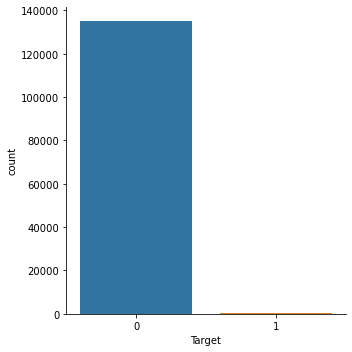

In [14]:
# Visualizando la variable target
# Se observa gran desbalance, 
#habrá que tratar esto ya que los algoritmos solo aprenderán a diferenciar los casos del target 0.
print("\nCantidad de elementos por Clase: ")
target_count = train['Target'].value_counts()

print('Clase 0:', target_count[0], "({:.3%})".format(round(target_count[0] / (target_count[0]+target_count[1]), 2)))
print('Clase 1:', target_count[1], "({:.3%})".format(round(target_count[1] / (target_count[0]+target_count[1]), 2)))
print('Total  :', train.shape[0])

sns.factorplot('Target', data = train, kind = 'count');

### Revisión de balance de clases por cada variable categórica de dataset de entrenamiento

In [16]:
# La variable DEPARTAMENTO presenta gran desbalance, LIMA se lleva el 75% de casos.
train.DEPARTAMENTO.value_counts(dropna=False)/train.shape[0]

LIMA                         0.748911
CALLAO                       0.048933
AREQUIPA                     0.044977
LA LIBERTAD                  0.034773
PIURA                        0.021309
LAMBAYEQUE                   0.016281
ICA                          0.012178
ANCASH                       0.010292
JUNIN                        0.009545
CUZCO                        0.009538
CAJAMARCA                    0.008274
MOQUEGUA                     0.005752
TACNA                        0.005508
SAN MARTIN                   0.004155
LORETO                       0.003860
UCAYALI                      0.002795
HUANUCO                      0.002721
PUNO                         0.002041
AYACUCHO                     0.001945
CERRO DE PASCO               0.001153
AMAZONAS                     0.001146
TUMBES                       0.001065
APURIMAC                     0.000961
MADRE DE DIOS                0.000843
NaN                          0.000569
HUANCAVELICA                 0.000473
Name: DEPART

In [17]:
# Se observan espacios innecesarios en los nombres de departamentos.
train.DEPARTAMENTO.unique()

array(['LIMA                     ', 'AREQUIPA                 ',
       'LAMBAYEQUE               ', 'CALLAO                   ',
       'CUZCO                    ', 'JUNIN                    ',
       'LA LIBERTAD              ', 'MOQUEGUA                 ',
       'UCAYALI                  ', 'ICA                      ',
       'PIURA                    ', 'SAN MARTIN               ',
       'CAJAMARCA                ', 'ANCASH                   ',
       'TACNA                    ', 'HUANCAVELICA             ',
       'LORETO                   ', 'CERRO DE PASCO           ',
       'APURIMAC                 ', 'TUMBES                   ',
       'AMAZONAS                 ', 'AYACUCHO                 ',
       'HUANUCO                  ', 'PUNO                     ',
       'MADRE DE DIOS            ', nan], dtype=object)

In [18]:
# Selecciono las variable de tipo string y limpio espacios en los valores.
columnas_string = train.select_dtypes(include='object').columns
train[columnas_string] = train[columnas_string].apply(lambda x: x.str.strip())

In [19]:
# Agrupo los departamentos diferentes de Lima y Callao en uno lista llamada provincias
departamentos = list(train.DEPARTAMENTO.unique())
provincias = list(filter(lambda x: x not in ['LIMA','CALLAO',np.nan], departamentos))
provincias

['AREQUIPA',
 'LAMBAYEQUE',
 'CUZCO',
 'JUNIN',
 'LA LIBERTAD',
 'MOQUEGUA',
 'UCAYALI',
 'ICA',
 'PIURA',
 'SAN MARTIN',
 'CAJAMARCA',
 'ANCASH',
 'TACNA',
 'HUANCAVELICA',
 'LORETO',
 'CERRO DE PASCO',
 'APURIMAC',
 'TUMBES',
 'AMAZONAS',
 'AYACUCHO',
 'HUANUCO',
 'PUNO',
 'MADRE DE DIOS']

In [20]:
# Se pueden agrupar los departamentos fuera de Lima y Callao en un solo grupo "PROVINCIAS"
train['DEPARTAMENTO'] = train['DEPARTAMENTO'].replace(provincias, 'PROVINCIAS')
train['DEPARTAMENTO'].replace({'CALLAO': 'LIMA'}, inplace=True)

In [22]:
# Los valores nulos se tratarán posteriormente, por ahora los dejo así.
train.DEPARTAMENTO.value_counts(dropna=False)/train.shape[0]

LIMA          0.797844
PROVINCIAS    0.201587
NaN           0.000569
Name: DEPARTAMENTO, dtype: float64

In [23]:
# SEGMENTO_BANCO: Existen clases de poca prsencia, se podrían agrupar.
train.SEGMENTO_BANCO.value_counts(dropna=False)/train.shape[0]

SEG_1      0.192100
SEG_2      0.183006
SEG_3      0.163908
SEG_4      0.135722
SEG_5      0.125385
SEG_6      0.104749
SEG_7      0.039254
SEG_8      0.027690
SIN_SEG    0.010581
SEG_09     0.009486
SEG_10     0.006425
NaN        0.000887
SEG_11     0.000806
Name: SEGMENTO_BANCO, dtype: float64

In [24]:
# Los valores nulos se rellenan con ponerles SIN_SEG
# Ojo que la ausencia de datos en esta variable podría deberse a otros factores externos que impidieron obtener la respuesta.
train.SEGMENTO_BANCO.fillna('SIN_SEG', inplace=True)

In [25]:
train.SEGMENTO_BANCO.value_counts(dropna=False)/train.shape[0]

SEG_1      0.192100
SEG_2      0.183006
SEG_3      0.163908
SEG_4      0.135722
SEG_5      0.125385
SEG_6      0.104749
SEG_7      0.039254
SEG_8      0.027690
SIN_SEG    0.011468
SEG_09     0.009486
SEG_10     0.006425
SEG_11     0.000806
Name: SEGMENTO_BANCO, dtype: float64

In [26]:
# Variable SEGMENTO_DIGITAL
train.SEGMENTO_DIGITAL.value_counts(dropna=False)/train.shape[0]

DIGITAL ALTO    0.858067
DIGITAL BAJO    0.099507
NO DIGITAL      0.042426
Name: SEGMENTO_DIGITAL, dtype: float64

In [27]:
# Variable NIVEL_SOCIECON
train.NIVEL_SOCIECON.value_counts(dropna=False)/train.shape[0]

D    0.611444
B    0.340643
A    0.045532
C    0.002381
Name: NIVEL_SOCIECON, dtype: float64

In [28]:
# Variable TIPNIVELEDUCACIONAL
train.TIPNIVELEDUCACIONAL.value_counts(dropna=False)/train.shape[0]

BAC    0.322284
TIT    0.189653
TEC    0.168824
SUP    0.146192
NDI    0.061081
TEI    0.032393
MAE    0.029450
SEC    0.026012
LIC    0.018603
DOC    0.002521
FAR    0.002470
PRI    0.000436
ANA    0.000081
Name: TIPNIVELEDUCACIONAL, dtype: float64

In [29]:
# Variable TIPSITUACIONLABORAL
train.TIPSITUACIONLABORAL.value_counts(dropna=False)/train.shape[0]

DEP    0.753348
IND    0.079906
SUC    0.065783
NDI    0.056600
EST    0.034544
INF    0.004983
JUB    0.004836
Name: TIPSITUACIONLABORAL, dtype: float64

In [30]:
# Variable TIPESTCIVIL
train.TIPESTCIVIL.value_counts(dropna=False)/train.shape[0]

SOL    0.604213
CAS    0.327083
SEP    0.034574
CBS    0.017413
CON    0.012126
VIU    0.004592
Name: TIPESTCIVIL, dtype: float64

In [31]:
# Variable FLGSEXO
train.FLGSEXO.value_counts(dropna=False)/train.shape[0]

M    0.633463
F    0.366537
Name: FLGSEXO, dtype: float64

Realizo imputación de la variable FLGSEXO ya que en la base de test si se tienen casos de valores nulos

In [32]:
# El  flag sexo también puede tener nulos
# Se puede imputar por la moda de la variable
def imputar_FLGSEXO(df, FLGSEXO):
    """
    Imputa los valores faltantes de FLGSEXO con su moda.
    
    Parameters:
        df (pandas.DataFrame): Dataframe que contiene los datos.
        FLGSEXO (str): Columna que se desea imputar.
        
    Returns:
        pandas.DataFrame: El dataframe con los valores faltantes imputados.
    """
    moda = df[FLGSEXO].mode()[0]
    df[FLGSEXO] = df[FLGSEXO].fillna(moda)
    return df

In [33]:
# Aplicando la imputación
train = imputar_FLGSEXO(train, 'FLGSEXO')

In [34]:
train.FLGSEXO.value_counts(dropna=False)/train.shape[0]

M    0.633463
F    0.366537
Name: FLGSEXO, dtype: float64

### Tratamiento de variables numéricas

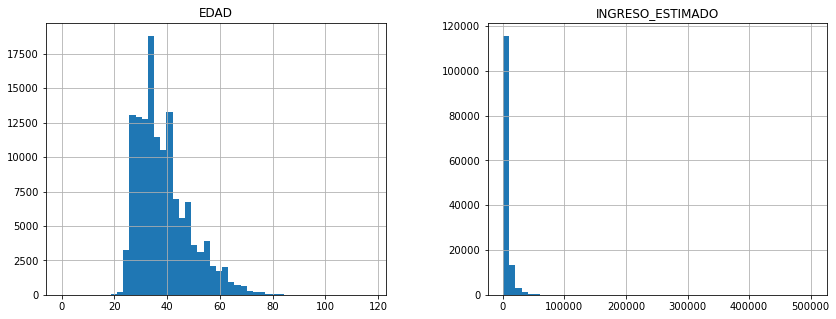

In [35]:
# Observo la distribución de las variables EDAD e INGRESO_ESTIMADO
train[['EDAD','INGRESO_ESTIMADO']].hist(bins=50, figsize=(14,5))
plt.show()

In [36]:
# Se observa valores inconsistentes en la variable edad, no pueden acceder menores de edad

def val_edad(df, EDAD):
    """
    rellena con valores nulos aquellos valores menores a 18 de la variable EDAD.
    
    Parameters:
        df (pandas.DataFrame): Dataframe que contiene los datos.
        EDAD (int): Variable edad a validar datos inconsistentes.
        
    Returns:
        pandas.DataFrame: El dataframe con los valores inconsistentes rellenados con null.
    """
    df[EDAD] = np.where(df[EDAD] < 18, np.nan, df[EDAD])
    return df

In [37]:
# Aplicando la validación de valores de edad inconsistentes
train = val_edad(train, 'EDAD')

In [38]:
train.EDAD.unique()

array([ 34.,  25.,  31.,  32.,  28.,  41.,  30.,  40.,  29.,  26.,  37.,
        50.,  35.,  52.,  36.,  33.,  38.,  70.,  46.,  44.,  42.,  54.,
        60.,  43.,  39.,  27.,  45.,  58.,  48.,  49.,  61.,  53.,  51.,
        56.,  65.,  62.,  63.,  47.,  55.,  68.,  57.,  24.,  67.,  66.,
        64.,  59.,  71.,  74.,  72.,  84.,  69.,  76.,  75.,  79.,  23.,
        22.,  78.,  77.,  20.,  87.,  82.,  21.,  73.,  80.,  81.,  83.,
        86.,  88.,  91.,  19.,  89., 117.,  nan,  85.,  90.,  18., 105.,
        92., 114.])

### Análisis de datos outliers en las variables numéricas

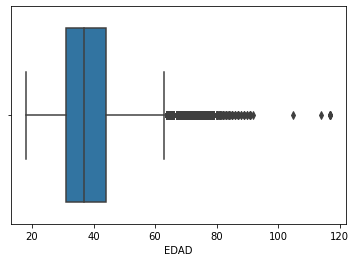

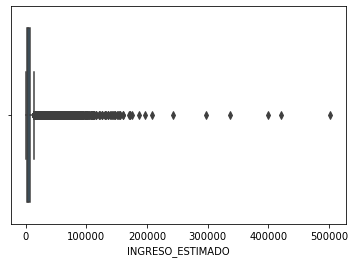

In [39]:
# EDAD, INGRESO_ESTIMADO
vars_num = ['EDAD', 'INGRESO_ESTIMADO']
for i in vars_num:
    sns.boxplot(x=train[i])
    plt.show()

In [40]:
# Acotando valores outliers de las variables numéricas
for i in vars_num:
    cuantil_25 = np.nanquantile(train[i], .25)
    cuantil_75 = np.nanquantile(train[i], .75)
    iqr = cuantil_75 - cuantil_25
    
    # Reemplazamos los valores outliers por el límite superior
    train.loc[train[i] > cuantil_75+1.5*iqr, i] = cuantil_75+1.5*iqr

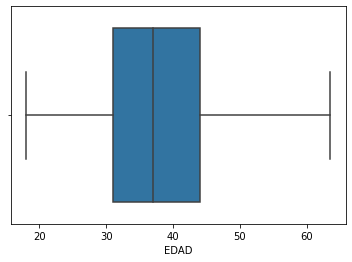

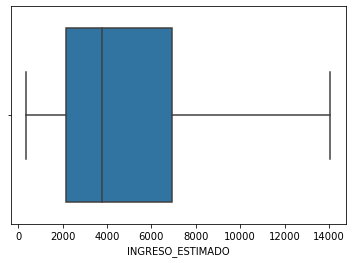

In [41]:
for i in vars_num:
    sns.boxplot(x=train[i])
    plt.show()

In [45]:
# Prueba estadística de correlación entre TIPESTCIVIL y EDAD:
from scipy.stats import pointbiserialr

df_sinna_edad = train.dropna(subset=['EDAD'])
# Calcular el coeficiente de correlación de punto biserial entre 'edad' y 'genero'
corr, pval = pointbiserialr(df_sinna_edad['EDAD'], df_sinna_edad['TIPESTCIVIL'].replace({'SOL': 0,'CON': 1,
                                                                                                 'CAS':2,'CBS':3,'SEP':4,
                                                                                                'VIU':5}))

# Imprimir el coeficiente de correlación y el valor p
print(f"Coeficiente de correlación de punto biserial: {corr}")
print(f"Valor p: {pval}")

Coeficiente de correlación de punto biserial: 0.5070927577184419
Valor p: 0.0


<AxesSubplot:xlabel='TIPESTCIVIL', ylabel='EDAD'>

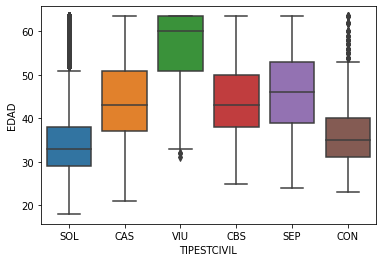

In [44]:
# Observo la relación entre el estado civil y la edad, tienen alguna relación?
# Esto porque la variable TIPESTCIVIL puede ayudarme a imputar los valores edad faltantes
sns.boxplot(data=df_sinna_edad, x="TIPESTCIVIL", y="EDAD")

In [46]:
# Imputación valores faltantes EDAD
train.loc[(train['TIPESTCIVIL'] == 'SOL') & (pd.isna(train['EDAD'])), 'EDAD'] = train[train['TIPESTCIVIL']=='SOL'].EDAD.median()
train.loc[(train['TIPESTCIVIL'] == 'CON') & (pd.isna(train['EDAD'])), 'EDAD'] = train[train['TIPESTCIVIL']=='CON'].EDAD.median()
train.loc[(train['TIPESTCIVIL'] == 'CAS') & (pd.isna(train['EDAD'])), 'EDAD'] = train[train['TIPESTCIVIL']=='CAS'].EDAD.median()
train.loc[(train['TIPESTCIVIL'] == 'CBS') & (pd.isna(train['EDAD'])), 'EDAD'] = train[train['TIPESTCIVIL']=='CBS'].EDAD.median()
train.loc[(train['TIPESTCIVIL'] == 'SEP') & (pd.isna(train['EDAD'])), 'EDAD'] = train[train['TIPESTCIVIL']=='SEP'].EDAD.median()
train.loc[(train['TIPESTCIVIL'] == 'VIU') & (pd.isna(train['EDAD'])), 'EDAD'] = train[train['TIPESTCIVIL']=='VIU'].EDAD.median()

In [47]:
# Prueba estadística de correlación entre NIVEL_SOCIECON y INGRESO_ESTIMADO:
from scipy.stats import pointbiserialr

df_sinna_ingreso = train.dropna(subset=['INGRESO_ESTIMADO'])
# Calcular el coeficiente de correlación de punto biserial entre 'edad' y 'genero'
corr, pval = pointbiserialr(df_sinna_ingreso['INGRESO_ESTIMADO'], df_sinna_ingreso['NIVEL_SOCIECON'].replace({'A': 0,'B': 1,'C':2,'D':3}))

# Imprimir el coeficiente de correlación y el valor p
print(f"Coeficiente de correlación de punto biserial: {corr}")
print(f"Valor p: {pval}")

Coeficiente de correlación de punto biserial: -0.7074033463326249
Valor p: 0.0


<AxesSubplot:xlabel='NIVEL_SOCIECON', ylabel='INGRESO_ESTIMADO'>

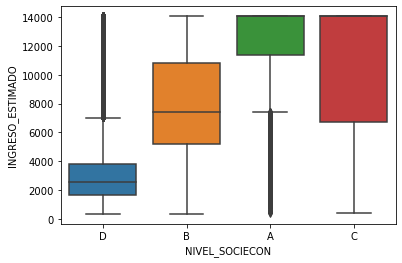

In [48]:
# Observo la relación entre el nivel socioeconómico y el ingreso estimado, tienen alguna relación?
# Esto porque la variable NIVEL_SOCIECON puede ayudarme a imputar los valores de INGRESO_ESTIMADO faltantes
sns.boxplot(data=df_sinna_ingreso, x="NIVEL_SOCIECON", y="INGRESO_ESTIMADO")

In [49]:
# Imputación valores faltantes INGRESO_ESTIMADO
train.loc[(train['NIVEL_SOCIECON'] == 'A') & (pd.isna(train['INGRESO_ESTIMADO'])), 'INGRESO_ESTIMADO'] = train[train['NIVEL_SOCIECON']=='A'].INGRESO_ESTIMADO.median()
train.loc[(train['NIVEL_SOCIECON'] == 'B') & (pd.isna(train['INGRESO_ESTIMADO'])), 'INGRESO_ESTIMADO'] = train[train['NIVEL_SOCIECON']=='B'].INGRESO_ESTIMADO.median()
train.loc[(train['NIVEL_SOCIECON'] == 'C') & (pd.isna(train['INGRESO_ESTIMADO'])), 'INGRESO_ESTIMADO'] = train[train['NIVEL_SOCIECON']=='C'].INGRESO_ESTIMADO.median()
train.loc[(train['NIVEL_SOCIECON'] == 'D') & (pd.isna(train['INGRESO_ESTIMADO'])), 'INGRESO_ESTIMADO'] = train[train['NIVEL_SOCIECON']=='D'].INGRESO_ESTIMADO.median()

In [50]:
train.isnull().sum()

FLGSEXO                 0
TIPESTCIVIL             0
TIPNIVELEDUCACIONAL     0
TIPSITUACIONLABORAL     0
EDAD                    0
DEPARTAMENTO           77
INGRESO_ESTIMADO        0
NIVEL_SOCIECON          0
SEGMENTO_DIGITAL        0
SEGMENTO_BANCO          0
Target                  0
dtype: int64

* Para tratar los valores faltantes en departamento se podría utilizar el segmento digital
* tengo el hipótesis de que clientes provenientes de provincias fuera de Lima sean menos digitales.

In [51]:
# Observo la distribución del nivel de digitalización de clientes en Lima 
train[train['DEPARTAMENTO']=='LIMA'].SEGMENTO_DIGITAL.value_counts(dropna=False)/train[train['DEPARTAMENTO']=='LIMA'].shape[0]

DIGITAL ALTO    0.870554
DIGITAL BAJO    0.091042
NO DIGITAL      0.038404
Name: SEGMENTO_DIGITAL, dtype: float64

In [52]:
# Observo la distribución del nivel de digitalización de clientes en provincias
train[train['DEPARTAMENTO']=='PROVINCIAS'].SEGMENTO_DIGITAL.value_counts(dropna=False)/train[train['DEPARTAMENTO']=='PROVINCIAS'].shape[0]

DIGITAL ALTO    0.808722
DIGITAL BAJO    0.133033
NO DIGITAL      0.058245
Name: SEGMENTO_DIGITAL, dtype: float64

In [53]:
# Observo la distribución del nivel de digitalización de clientes con valores faltantes de departamento
train[train['DEPARTAMENTO'].isna()].SEGMENTO_DIGITAL.value_counts(dropna=False)/train[train['DEPARTAMENTO'].isna()].shape[0]

DIGITAL ALTO    0.831169
DIGITAL BAJO    0.090909
NO DIGITAL      0.077922
Name: SEGMENTO_DIGITAL, dtype: float64

De lo observado se puede concluir que si existe una relación entre la ubicación y el nivel de digitalización.

In [54]:
# Imputación del departamento
train.loc[(train['SEGMENTO_DIGITAL'].isin(['DIGITAL BAJO', 'NO DIGITAL'])) & (pd.isna(train['DEPARTAMENTO'])), 'DEPARTAMENTO'] = 'PROVINCIAS'
train.loc[(train['SEGMENTO_DIGITAL'] == 'DIGITAL ALTO') & (pd.isna(train['DEPARTAMENTO'])), 'DEPARTAMENTO'] = 'LIMA'

In [55]:
train.DEPARTAMENTO.value_counts()

LIMA          107970
PROVINCIAS     27277
Name: DEPARTAMENTO, dtype: int64

In [56]:
train.isnull().sum()

FLGSEXO                0
TIPESTCIVIL            0
TIPNIVELEDUCACIONAL    0
TIPSITUACIONLABORAL    0
EDAD                   0
DEPARTAMENTO           0
INGRESO_ESTIMADO       0
NIVEL_SOCIECON         0
SEGMENTO_DIGITAL       0
SEGMENTO_BANCO         0
Target                 0
dtype: int64

## Visualización de las variables 
Se presentan la distribución de frecuencias de cada variable en el dataset de entrenamiento

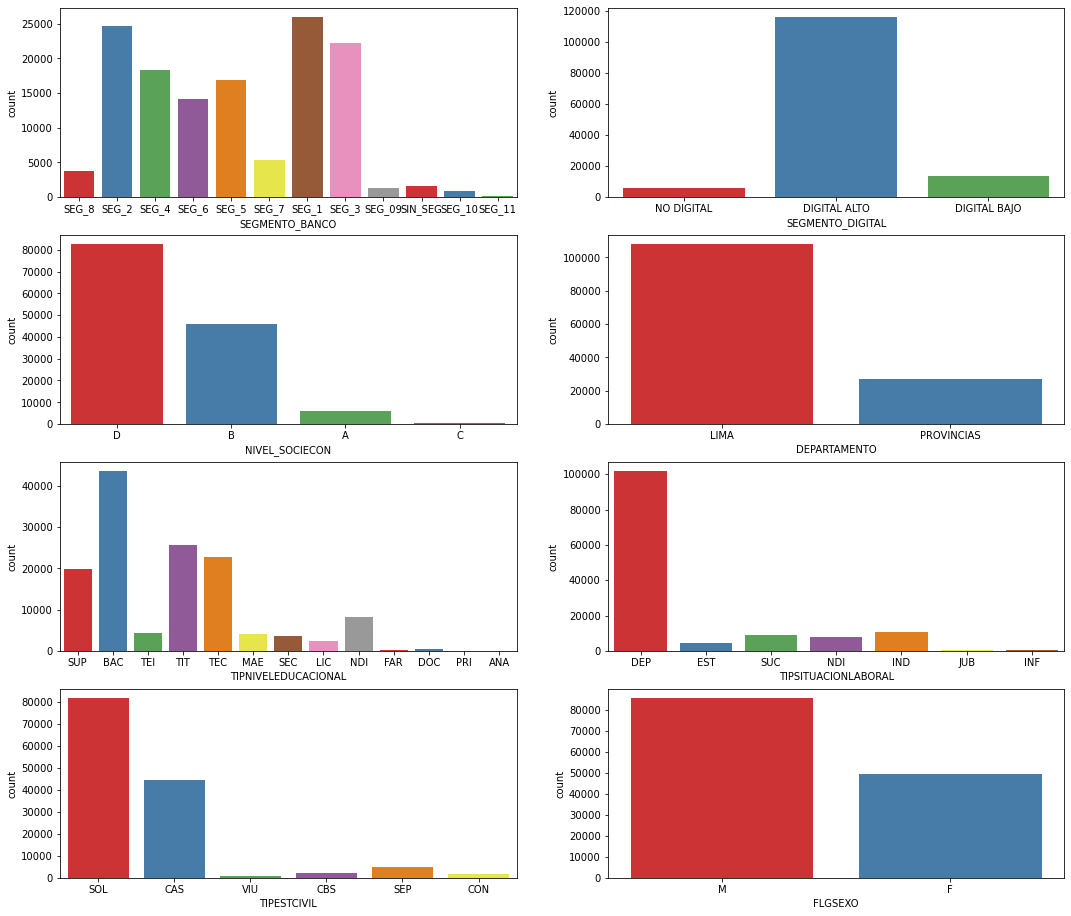

In [58]:
# Visualización de variables categóricas

fig, ax =plt.subplots(4,2,figsize = (18,16))
sns.countplot(x= 'SEGMENTO_BANCO', data = train, palette = 'Set1', ax=ax[0,0])
sns.countplot(x= 'SEGMENTO_DIGITAL', data = train, palette = 'Set1', ax=ax[0,1])
sns.countplot(x= 'NIVEL_SOCIECON', data = train, palette = 'Set1', ax=ax[1,0])
sns.countplot(x= 'DEPARTAMENTO', data = train, palette = 'Set1', ax=ax[1,1])
sns.countplot(x= 'TIPNIVELEDUCACIONAL', data = train, palette = 'Set1', ax=ax[2,0])
sns.countplot(x= 'TIPSITUACIONLABORAL', data = train, palette = 'Set1', ax=ax[2,1])
sns.countplot(x= 'TIPESTCIVIL', data = train, palette = 'Set1', ax=ax[3,0])
sns.countplot(x= 'FLGSEXO', data = train, palette = 'Set1', ax=ax[3,1])

fig.show()

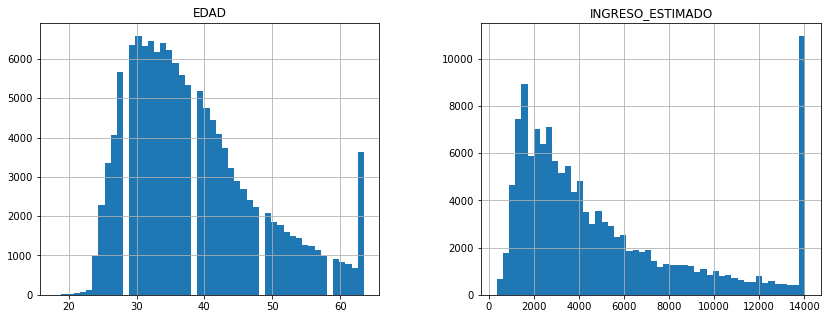

In [59]:
# Visualización de distribución de variables numéricas

train[['EDAD','INGRESO_ESTIMADO']].hist(bins=50, figsize=(14,5))
plt.show()

## Análisis de correlación

In [62]:
# Correlación de la variable target con las variables numéricas
# Utilizo el método spearman porque describe mejor variables correlacionadas de forma no lineal
train.Target = train.Target.astype(int)
train[['EDAD','INGRESO_ESTIMADO','Target']].corr(method='spearman')

,EDAD,INGRESO_ESTIMADO,Target
EDAD,1.000000,0.273204,-0.001274
INGRESO_ESTIMADO,0.273204,1.000000,0.032928
Target,-0.001274,0.032928,1.000000


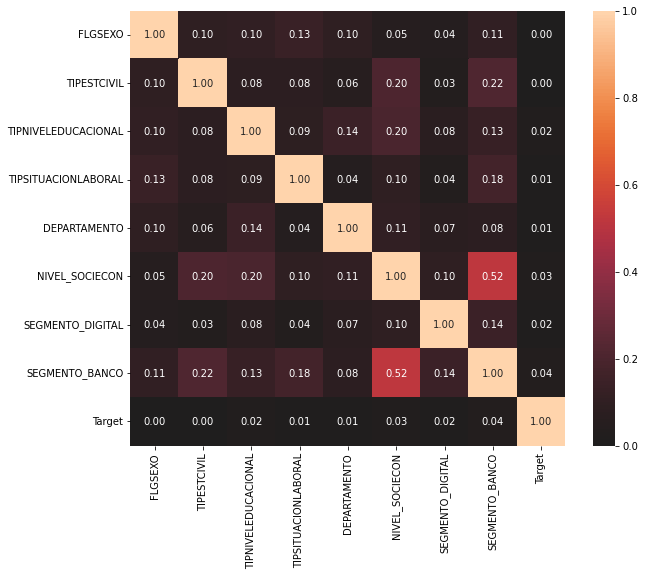

In [63]:
# Correlación de la variable target con las variables categóricas
# Se utliza las asociaciones de Cramer para variables categóricas

train.Target = train.Target.astype(str)
columnas_string = train.select_dtypes(include='object').columns

fig, ax = plt.subplots(figsize = (10, 8))

# Estimación y generación de la matriz deasociación de Cramer
cramers_v = associations(train[columnas_string], 
                         nom_nom_assoc = 'cramer', ax = ax)

### Conclusión: no se tienen variables altamente correlacionadas entre si. Se puede trabajar con todas.

## Preparación de matriz de modelamiento

### Transformación de variables categóricas a numéricas
Los algoritmos en general solo entienden valores de entrada de naturaleza numéricas, es necesario transformar las variables categóricas.

In [65]:
# Se tiene previamente una lista con las variables categóricas
columnas_string

Index(['FLGSEXO', 'TIPESTCIVIL', 'TIPNIVELEDUCACIONAL', 'TIPSITUACIONLABORAL',
       'DEPARTAMENTO', 'NIVEL_SOCIECON', 'SEGMENTO_DIGITAL', 'SEGMENTO_BANCO',
       'Target'],
      dtype='object')

In [66]:
# Aplico una transformación dummies para crear nuevas columnas a partir de las diferntes clases de cada variable categórica.
nuevas_columnas = pd.get_dummies(train[columnas_string].drop('Target', axis=1))
list_nuevas_columnas = [x for x in columnas_string if x not in ['Target']]

train = pd.concat([train, nuevas_columnas], axis=1)
train.drop(list_nuevas_columnas+['FLGSEXO_F','DEPARTAMENTO_PROVINCIAS'], axis=1, inplace=True)

In [67]:
train

,EDAD,INGRESO_ESTIMADO,Target,FLGSEXO_M,TIPESTCIVIL_CAS,TIPESTCIVIL_CBS,TIPESTCIVIL_CON,TIPESTCIVIL_SEP,TIPESTCIVIL_SOL,TIPESTCIVIL_VIU,TIPNIVELEDUCACIONAL_ANA,TIPNIVELEDUCACIONAL_BAC,TIPNIVELEDUCACIONAL_DOC,TIPNIVELEDUCACIONAL_FAR,TIPNIVELEDUCACIONAL_LIC,TIPNIVELEDUCACIONAL_MAE,TIPNIVELEDUCACIONAL_NDI,TIPNIVELEDUCACIONAL_PRI,TIPNIVELEDUCACIONAL_SEC,TIPNIVELEDUCACIONAL_SUP,TIPNIVELEDUCACIONAL_TEC,TIPNIVELEDUCACIONAL_TEI,TIPNIVELEDUCACIONAL_TIT,TIPSITUACIONLABORAL_DEP,TIPSITUACIONLABORAL_EST,TIPSITUACIONLABORAL_IND,TIPSITUACIONLABORAL_INF,TIPSITUACIONLABORAL_JUB,TIPSITUACIONLABORAL_NDI,TIPSITUACIONLABORAL_SUC,DEPARTAMENTO_LIMA,NIVEL_SOCIECON_A,NIVEL_SOCIECON_B,NIVEL_SOCIECON_C,NIVEL_SOCIECON_D,SEGMENTO_DIGITAL_DIGITAL ALTO,SEGMENTO_DIGITAL_DIGITAL BAJO,SEGMENTO_DIGITAL_NO DIGITAL,SEGMENTO_BANCO_SEG_09,SEGMENTO_BANCO_SEG_1,SEGMENTO_BANCO_SEG_10,SEGMENTO_BANCO_SEG_11,SEGMENTO_BANCO_SEG_2,SEGMENTO_BANCO_SEG_3,SEGMENTO_BANCO_SEG_4,SEGMENTO_BANCO_SEG_5,SEGMENTO_BANCO_SEG_6,SEGMENTO_BANCO_SEG_7,SEGMENTO_BANCO_SEG_8,SEGMENTO_BANCO_SIN_SEG
66274,34.0,750.780000,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
62670,25.0,2898.245000,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
157834,31.0,2608.920000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
51377,32.0,8324.367500,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
85409,28.0,1358.930688,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146449,29.0,3520.500000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
119906,36.0,1773.330000,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
17730,42.0,9324.215000,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
28030,31.0,9029.652500,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Análisis Bivariado
El objetivo es observar qué variables están mejor asociadas a la variable target.
Utilizo el indicador Information Value (IV) que mide el grado de asociación. Valores más altos indican mejor asociación.

In [69]:
# Función para calcular los IV
import woe
from woe.eval import plot_ks
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
import warnings
warnings.filterwarnings('ignore')
max_bin = 20
force_bin = 3


# Creamos las Woes - IV
max_bin = 20
force_bin = 3

def mono_bin(Y, X, n = max_bin):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)


def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)


def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [70]:
# La función acepta valores enteros, transformo el taget a entero para no tener problemas
train.Target = train.Target.astype(int)

In [71]:
# Obtención de los IV
final_iv, IV = data_vars(train, train.Target)

In [72]:
# tabla ordenada de las variables por su IV respecto al target
IV.sort_values('IV',ascending=False)

,VAR_NAME,IV
3,INGRESO_ESTIMADO,5.302080e-01
7,NIVEL_SOCIECON_D,2.764226e-01
39,TIPNIVELEDUCACIONAL_TEC,2.397515e-01
20,SEGMENTO_DIGITAL_DIGITAL ALTO,2.068298e-01
9,SEGMENTO_BANCO_SEG_1,1.610619e-01
21,SEGMENTO_DIGITAL_DIGITAL BAJO,1.550481e-01
17,SEGMENTO_BANCO_SEG_7,1.498835e-01
4,NIVEL_SOCIECON_A,1.469742e-01
14,SEGMENTO_BANCO_SEG_4,1.031554e-01
5,NIVEL_SOCIECON_B,9.715629e-02


### Ahora que ya tenemos las variables preprocesadas para la antrada a un algoritmo, se procede a exportarlo para realizar las pruebas y entrenamiento del modelo en un ambiente en la nube de google colaboratory.
### El escalamiento lo realizo en el otro ambiente

In [73]:
train.to_csv('../data/preprocess/train_pre_normalize.csv', index=False)

### Preparación de la base de test, se aplican las mismas transformaciones de variables que en el dataset de train

### Dataset para el scoring del modelo

In [74]:
test.drop('ID_SEC', axis=1, inplace=True)
columnas_string = test.select_dtypes(include='object').columns
test[columnas_string] = test[columnas_string].apply(lambda x: x.str.strip())
departamentos = list(test.DEPARTAMENTO.unique())
provincias = list(filter(lambda x: x not in ['LIMA','CALLAO',np.nan], departamentos))
test['DEPARTAMENTO'] = test['DEPARTAMENTO'].replace(provincias, 'PROVINCIAS')
test['DEPARTAMENTO'].replace({'CALLAO': 'LIMA'}, inplace=True)
test.SEGMENTO_BANCO.fillna('SIN_SEG', inplace=True)

In [75]:
test = imputar_FLGSEXO(test, 'FLGSEXO')
test = val_edad(test, 'EDAD')

In [76]:
for i in vars_num:
    cuantil_25 = np.nanquantile(test[i], .25)
    cuantil_75 = np.nanquantile(test[i], .75)
    iqr = cuantil_75 - cuantil_25
    
    # Reemplazamos los valores outliers por el límite superior
    test.loc[test[i] > cuantil_75+1.5*iqr, i] = cuantil_75+1.5*iqr

In [77]:
test.loc[(test['TIPESTCIVIL'] == 'SOL') & (pd.isna(test['EDAD'])), 'EDAD'] = test[test['TIPESTCIVIL']=='SOL'].EDAD.median()
test.loc[(test['TIPESTCIVIL'] == 'CON') & (pd.isna(test['EDAD'])), 'EDAD'] = test[test['TIPESTCIVIL']=='CON'].EDAD.median()
test.loc[(test['TIPESTCIVIL'] == 'CAS') & (pd.isna(test['EDAD'])), 'EDAD'] = test[test['TIPESTCIVIL']=='CAS'].EDAD.median()
test.loc[(test['TIPESTCIVIL'] == 'CBS') & (pd.isna(test['EDAD'])), 'EDAD'] = test[test['TIPESTCIVIL']=='CBS'].EDAD.median()
test.loc[(test['TIPESTCIVIL'] == 'SEP') & (pd.isna(test['EDAD'])), 'EDAD'] = test[test['TIPESTCIVIL']=='SEP'].EDAD.median()
test.loc[(test['TIPESTCIVIL'] == 'VIU') & (pd.isna(test['EDAD'])), 'EDAD'] = test[test['TIPESTCIVIL']=='VIU'].EDAD.median()

test.loc[(test['NIVEL_SOCIECON'] == 'A') & (pd.isna(test['INGRESO_ESTIMADO'])), 'INGRESO_ESTIMADO'] = test[test['NIVEL_SOCIECON']=='A'].INGRESO_ESTIMADO.median()
test.loc[(test['NIVEL_SOCIECON'] == 'B') & (pd.isna(test['INGRESO_ESTIMADO'])), 'INGRESO_ESTIMADO'] = test[test['NIVEL_SOCIECON']=='B'].INGRESO_ESTIMADO.median()
test.loc[(test['NIVEL_SOCIECON'] == 'C') & (pd.isna(test['INGRESO_ESTIMADO'])), 'INGRESO_ESTIMADO'] = test[test['NIVEL_SOCIECON']=='C'].INGRESO_ESTIMADO.median()
test.loc[(test['NIVEL_SOCIECON'] == 'D') & (pd.isna(test['INGRESO_ESTIMADO'])), 'INGRESO_ESTIMADO'] = test[test['NIVEL_SOCIECON']=='D'].INGRESO_ESTIMADO.median()

In [78]:
test.loc[(test['SEGMENTO_DIGITAL'].isin(['DIGITAL BAJO', 'NO DIGITAL'])) & (pd.isna(test['DEPARTAMENTO'])), 'DEPARTAMENTO'] = 'PROVINCIAS'
test.loc[(test['SEGMENTO_DIGITAL'] == 'DIGITAL ALTO') & (pd.isna(test['DEPARTAMENTO'])), 'DEPARTAMENTO'] = 'LIMA'

In [79]:
columnas_string

Index(['FLGSEXO', 'TIPESTCIVIL', 'TIPNIVELEDUCACIONAL', 'TIPSITUACIONLABORAL',
       'DEPARTAMENTO', 'NIVEL_SOCIECON', 'SEGMENTO_DIGITAL', 'SEGMENTO_BANCO'],
      dtype='object')

In [80]:
test.Target = test.Target.astype(int)
nuevas_columnas = pd.get_dummies(test[columnas_string])
list_nuevas_columnas = [x for x in columnas_string if x not in ['Target']]

test = pd.concat([test, nuevas_columnas], axis=1)
test.drop(list_nuevas_columnas+['FLGSEXO_F','DEPARTAMENTO_PROVINCIAS'], axis=1, inplace=True)

In [81]:
test

,EDAD,INGRESO_ESTIMADO,Target,FLGSEXO_M,TIPESTCIVIL_CAS,TIPESTCIVIL_CBS,TIPESTCIVIL_CON,TIPESTCIVIL_SEP,TIPESTCIVIL_SOL,TIPESTCIVIL_VIU,TIPNIVELEDUCACIONAL_BAC,TIPNIVELEDUCACIONAL_DOC,TIPNIVELEDUCACIONAL_FAR,TIPNIVELEDUCACIONAL_LIC,TIPNIVELEDUCACIONAL_MAE,TIPNIVELEDUCACIONAL_NDI,TIPNIVELEDUCACIONAL_PRI,TIPNIVELEDUCACIONAL_SEC,TIPNIVELEDUCACIONAL_SUP,TIPNIVELEDUCACIONAL_TEC,TIPNIVELEDUCACIONAL_TEI,TIPNIVELEDUCACIONAL_TIT,TIPSITUACIONLABORAL_DEP,TIPSITUACIONLABORAL_EST,TIPSITUACIONLABORAL_IND,TIPSITUACIONLABORAL_INF,TIPSITUACIONLABORAL_JUB,TIPSITUACIONLABORAL_NDI,TIPSITUACIONLABORAL_SUC,DEPARTAMENTO_LIMA,NIVEL_SOCIECON_A,NIVEL_SOCIECON_B,NIVEL_SOCIECON_C,NIVEL_SOCIECON_D,SEGMENTO_DIGITAL_DIGITAL ALTO,SEGMENTO_DIGITAL_DIGITAL BAJO,SEGMENTO_DIGITAL_NO DIGITAL,SEGMENTO_BANCO_SEG_09,SEGMENTO_BANCO_SEG_1,SEGMENTO_BANCO_SEG_10,SEGMENTO_BANCO_SEG_11,SEGMENTO_BANCO_SEG_2,SEGMENTO_BANCO_SEG_3,SEGMENTO_BANCO_SEG_4,SEGMENTO_BANCO_SEG_5,SEGMENTO_BANCO_SEG_6,SEGMENTO_BANCO_SEG_7,SEGMENTO_BANCO_SEG_8,SEGMENTO_BANCO_SIN_SEG
138620,39.0,5703.23000,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4250,42.0,11898.65000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
87318,45.0,14015.72375,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
98113,42.0,11619.12000,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
116876,52.0,1470.54000,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143741,35.0,2988.97500,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
30473,33.0,2987.73500,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
14991,43.0,7041.73750,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
168940,40.0,10584.99000,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [724]:
test.to_csv('../data/preprocess/test_pre_normalize.csv', index=False)